In [35]:
#run file where I've offloaded all my imports and default parameters
%run 'DefaultParams.py'

#import EqW measurement routine that Kristen stole from UVES tutorial and Kevin hacked to make sense to him.
%run 'SpectrumFunctions.py'

#ensure that plots show up in our notebook (comment this out if converting to a script)
%matplotlib inline

In [2]:
#Read in AA Tau's 2008 IR spectrum, starting with the IR channel (using function Kevin made from Kristen's fancy code)
IRSpec_2008_wavelength, IRSpec_2008_flux = readSpectrum('spectra/AATau_IR2008.txt', u.micron)

#Now read in AA Tau's 2008 optical spectrum
OptSpec_2008_wavelength, OptSpec_2008_flux = readSpectrum('spectra/AATau_opt2008.txt', u.micron)

#Now read in AA Tau's 2014 IR spectra
IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux = readSpectrum('spectra/AATau_IR2014dec02.txt', u.micron)
IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux = readSpectrum('spectra/AATau_IR2014dec12.txt', u.micron)

#Now read in AA Tau's 2014 optical spectra
OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux = readSpectrum('spectra/AATau_opt2014dec02.txt', u.micron)
OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux = readSpectrum('spectra/AATau_opt2014dec12.txt', u.micron)

#Read in AA Tau's 2012 Xshooter spectra
#IRSpec_2012_wavelength, IRSpec_2012_flux = readSpectrum('spectra/AA_Tau_2012_Xshooter.NIR.spec', u.micron)
#optSpec_2012_wavelength, optSpec_2012_flux = readSpectrum('spectra/AA_Tau_2012_Xshooter.VIS.spec', u.micron)
#UVSpec_2012_wavelength, UVSpec_2012_flux = readSpectrum('spectra/AA_Tau_2012_Xshooter.UVS.spec', u.micron)

#Read in AA Tau's 1998 NICMOS spectra
IRSpec_1998_wavelength, IRSpec_1998_flux = readSpectrum('spectra/AA_Tau_1998_NICMOS.spec', u.micron)

#Read in AA Tau's 2006 SpeX spectra
IRSpec_2006_wavelength, IRSpec_2006_flux = np.loadtxt('spectra/aatau.27nov06.txt', usecols=range(2), skiprows=117, unpack=True) 

In [3]:
n_uv_smooth = 35
n_uv_smooth_over2 = (n_uv_smooth-1)/2

n_opt_smooth = 59
n_opt_smooth_over2 = (n_opt_smooth-1)/2

n_nir_smooth = 9
n_nir_smooth_over2 = (n_nir_smooth-1)/2

#read in Carlo Manara's reductions of the X-shooter data
# - read in NIR spectra
nir_hdulist = fits.open('spectra/XShooterFromCarlos/AATau_flux_tell_nir.fits')
nir_header = nir_hdulist[0].header
IRSpec_2012_flux = nir_hdulist[0].data/10.
IRSpec_2012_wavelength_air = (nir_hdulist[0].header['CRVAL1']+0.06*np.linspace(0,24749, num = 24750))/1000.
#Make a low-pass filter to smooth the spectrum to TSPEC-like resolution
#box_kernel = Box1DKernel(5)b, a = signal.butter(9, 0.1)
#Filtered_IRSpec_2012_flux = signal.filtfilt(b, a, IRSpec_2012_flux)
#box_kernel = Box1DKernel(13)
Filtered_IRSpec_2012_flux = running_mean(IRSpec_2012_flux, n_nir_smooth)

# - read in NIR spectra_iraf
nir_iraf_hdulist = fits.open('spectra/XShooterFromCarlos/AATau_flux_tell_iraf_nir.fits')
nir_iraf_header = nir_iraf_hdulist[0].header
IRSpec_2012_flux_iraf = nir_iraf_hdulist[0].data/10.
#Make a low-pass filter to smooth the spectrum to TSPEC-like resolution
#b, a = signal.butter(9, 0.1)
#Filtered_IRSpec_2012_flux_iraf = signal.filtfilt(b, a, IRSpec_2012_flux_iraf)
Filtered_IRSpec_2012_flux_iraf = running_mean(IRSpec_2012_flux_iraf, n_nir_smooth)

# - read in Optical spectra
vis_iraf_hdulist = fits.open('spectra/XShooterFromCarlos/AATau_flux_tell_iraf_vis.fits')
vis_iraf_header = vis_iraf_hdulist[0].header
OptSpec_2012_flux_iraf = vis_iraf_hdulist[0].data/10.
Filtered_OptSpec_2012_flux_iraf = running_mean(OptSpec_2012_flux_iraf, n_opt_smooth)

# - read in Optical spectra
vis_hdulist = fits.open('spectra/XShooterFromCarlos/AATau_flux_tell_vis.fits')
vis_header = vis_hdulist[0].header
OptSpec_2012_flux = vis_hdulist[0].data/10.
OptSpec_2012_wavelength_air = (vis_hdulist[0].header['CRVAL1']+0.02*np.linspace(0,24317, num = 24318))/1000.
Filtered_OptSpec_2012_flux = running_mean(OptSpec_2012_flux, n_opt_smooth)

# - read in UV spectra
uvb_hdulist = fits.open('spectra/XShooterFromCarlos/AATau_flux_uvb.fits')
uvb_header = uvb_hdulist[0].header
UVSpec_2012_flux = uvb_hdulist[0].data/10.
Filtered_UVSpec_2012_flux = running_mean(UVSpec_2012_flux, n_uv_smooth)

UVSpec_2012_wavelength_air = (uvb_hdulist[0].header['CRVAL1']+0.02*np.linspace(0,14554, num = 14555))/1000.

In [4]:
### Convert Optical and X-shooter spectra to vacuum wavelengths, so that everything is on a consistent system.



#convert the Xshooter spectrum to vacuum wavelengths, based on working assumption that TSPEC reduction pipeline 
#inherited the SpeX calibrations which are in vacuum units. 
#To do this, need to use the edlen conversion (only one that extends past H band) and do the conversion in Angstroms
IRSpec_2012_wavelength = pyasl.airtovac2(IRSpec_2012_wavelength_air*10000., mode='edlen53', precision=1e-9)/10000.
OptSpec_2012_wavelength = pyasl.airtovac2(OptSpec_2012_wavelength_air*10000., mode='edlen53')/10000.
UVSpec_2012_wavelength = pyasl.airtovac2(UVSpec_2012_wavelength_air*10000., mode='edlen53')/10000.

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


24742 24742


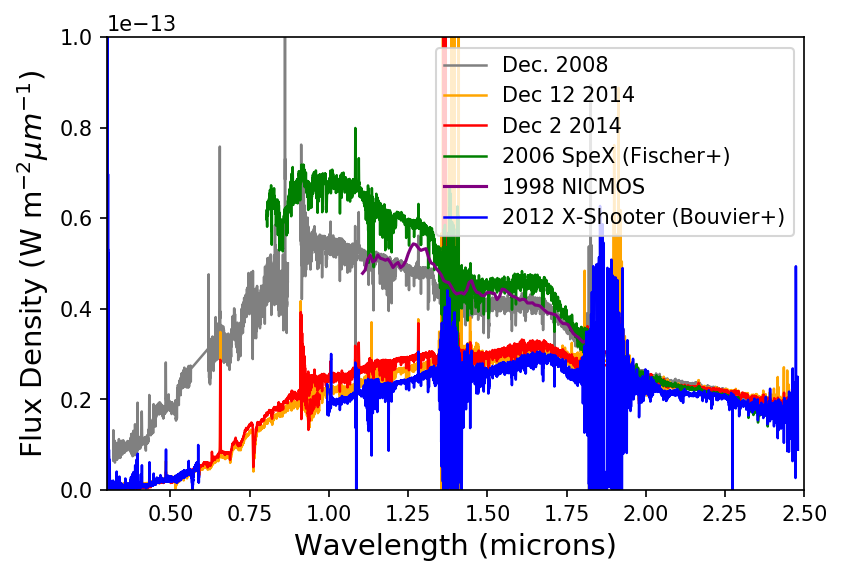

In [27]:
#now plot all the spectra 
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 1.2, color = 'grey', label = 'Dec. 2008')
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux, linewidth = 1.2, color = 'grey')

plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = 'Dec 12 2014')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange')

plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = 'Dec 2 2014')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 1.2, color = 'red')

plt.plot(IRSpec_2006_wavelength, IRSpec_2006_flux, linewidth = 1.2, color = 'green', label = '2006 SpeX (Fischer+)')
plt.plot(IRSpec_1998_wavelength, IRSpec_1998_flux, linewidth = 1.5, color = 'purple', label = '1998 NICMOS')

print(len(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2]), len(Filtered_IRSpec_2012_flux))
#plt.plot(IRSpec_2012_wavelength, IRSpec_2012_flux/10., linewidth = 1.2, color = 'blue')
plt.plot(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth = 1.2, color = 'blue', label = '2012 X-Shooter (Bouvier+)')
plt.plot(OptSpec_2012_wavelength, OptSpec_2012_flux, linewidth = 1.2, color = 'blue')
plt.plot(UVSpec_2012_wavelength, UVSpec_2012_flux, linewidth = 1.2, color = 'blue')

#And now compute and overlay the blackbody curve
#scaled_solarlike_blackbody = planckMicron(wavelength_microns[:],5770)/(1.5E10)

#plt.plot(wavelength_microns[:],scaled_solarlike_blackbody,linewidth = 4, color = 'y')
plt.axis([0.3,2.5,0,1E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu m^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 10
plt.legend(loc="best")

plt.savefig('FullSpectrum.png', bbox_inches='tight')

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


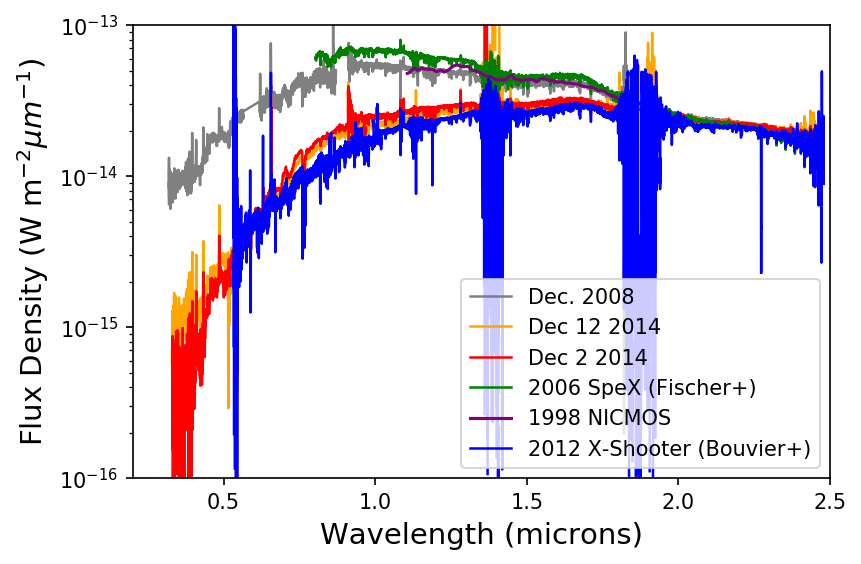

In [28]:
#now plot all the spectra 
plt.semilogy(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 1.2, color = 'grey', label = 'Dec. 2008')
plt.semilogy(OptSpec_2008_wavelength, OptSpec_2008_flux, linewidth = 1.2, color = 'grey')

plt.semilogy(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = 'Dec 12 2014')
plt.semilogy(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange')

plt.semilogy(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = 'Dec 2 2014')
plt.semilogy(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 1.2, color = 'red')

plt.semilogy(IRSpec_2006_wavelength, IRSpec_2006_flux, linewidth = 1.2, color = 'green', label = '2006 SpeX (Fischer+)')
plt.semilogy(IRSpec_1998_wavelength, IRSpec_1998_flux, linewidth = 1.5, color = 'purple', label = '1998 NICMOS')

#plt.plot(IRSpec_2012_wavelength, IRSpec_2012_flux/10., linewidth = 1.2, color = 'blue')
plt.semilogy(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth = 1.2, color = 'blue', label = '2012 X-Shooter (Bouvier+)')
plt.semilogy(OptSpec_2012_wavelength, OptSpec_2012_flux, linewidth = 1.2, color = 'blue')
plt.semilogy(UVSpec_2012_wavelength, UVSpec_2012_flux, linewidth = 1.2, color = 'blue')

#And now compute and overlay the blackbody curve
#scaled_solarlike_blackbody = planckMicron(wavelength_microns[:],5770)/(1.5E10)

#plt.plot(wavelength_microns[:],scaled_solarlike_blackbody,linewidth = 4, color = 'y')
plt.axis([0.2,2.5,1E-16,1E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu m^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 10
plt.legend(loc="best")

plt.savefig('FullSpectrum_log.png', bbox_inches='tight')

### Measure H$\alpha$ EqW

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


H$\alpha$ EqW:  20.3724999058 32.401795887 33.5042922223 30.0240313079 49.5037279774
H$\alpha$ line flux:  6.759524165e-17 2.27462770443e-17 2.32466964389e-17 2.46633065708e-17 3.56165164731e-17


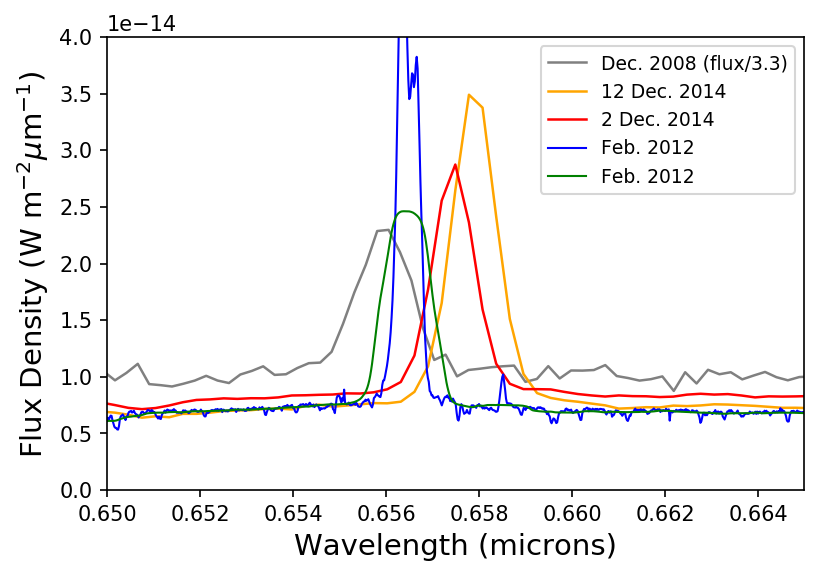

In [7]:
#Now make a plot that zooms in on Halpha
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux/3.3, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/3.3)')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(OptSpec_2012_wavelength, OptSpec_2012_flux, linewidth = 1, color = 'blue', label = 'Feb. 2012')
plt.plot(OptSpec_2012_wavelength[n_opt_smooth_over2:-n_opt_smooth_over2], Filtered_OptSpec_2012_flux, linewidth = 1, color = 'green', label = 'Feb. 2012')

#plt.plot(UVSpec_2012_wavelength, UVSpec_2012_flux, linewidth = 2, color = 'grey')

plt.axis([0.65,0.665,0,0.4E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

#define the Halpha line parameters
ha_line = [0.654,0.660]
ha_cont_blue = [0.651,0.654]
ha_cont_red = [0.660,0.663]

#Now measure the EqWs (and the line fluxes)
HaEqW_2008, HaFluxW_2008, ha_wave_2008, ha_flux_2008 = measureEqW(OptSpec_2008_wavelength, OptSpec_2008_flux, ha_line, ha_cont_blue, ha_cont_red)
Filt_HaEqW_2012, Filt_HaFluxW_2012,  Filt_ha_wave_2012, Filt_ha_flux_2012 = measureEqW(OptSpec_2012_wavelength[n_opt_smooth_over2:-n_opt_smooth_over2], Filtered_OptSpec_2012_flux, ha_line, ha_cont_blue, ha_cont_red)
HaEqW_2012, HaFluxW_2012,  ha_wave_2012, ha_flux_2012 = measureEqW(OptSpec_2012_wavelength, OptSpec_2012_flux, ha_line, ha_cont_blue, ha_cont_red)
HaEqW_2dec2014, HaFluxW_2dec2014,  ha_wave_2dec2014, ha_flux_2dec2014 = measureEqW(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, ha_line, ha_cont_blue, ha_cont_red)
HaEqW_12dec2014, HaFluxW_12dec2014, ha_wave_12dec2014, ha_flux_12dec2014 = measureEqW(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, ha_line, ha_cont_blue, ha_cont_red)

#now print out the measurements for hand-typing into paper
print(r'H$\alpha$ EqW: ', 10000*HaEqW_2008, 10000*HaEqW_2012, 10000*Filt_HaEqW_2012, 10000*HaEqW_2dec2014, 10000*HaEqW_12dec2014)
print(r'H$\alpha$ line flux: ', HaFluxW_2008, HaFluxW_2012, Filt_HaFluxW_2012, HaFluxW_2dec2014, HaFluxW_12dec2014)

### Measure H$\beta$ EqW

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


H$\beta$ EqW:  5.44930560955 10.6977378633 9.03848684213 12.9025680148
H$\beta$ line flux:  9.9523393e-18 2.54622783505e-18 1.8786037102e-18 3.3980063131e-18


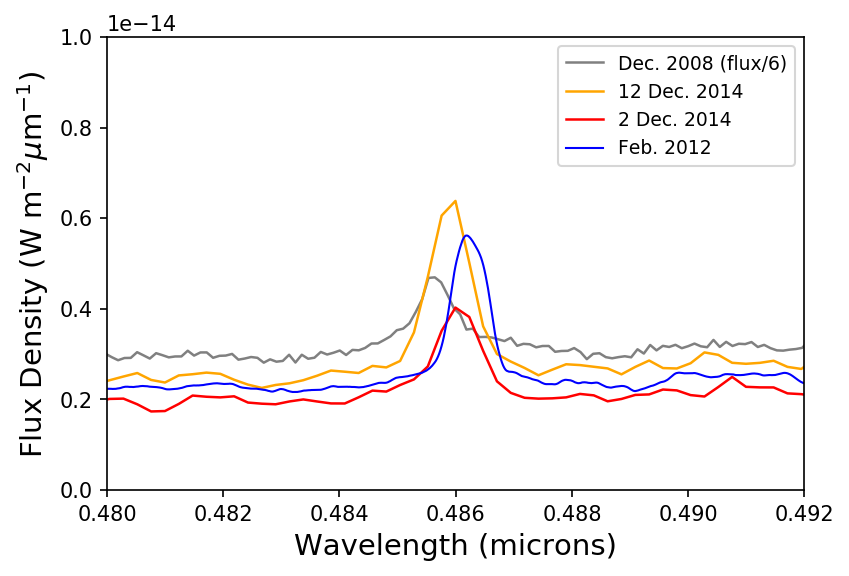

In [8]:
#Now make a plot that zooms in on Hbeta
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux/6, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/6)')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
#plt.plot(OptSpec_2012_wavelength, OptSpec_2012_flux, linewidth = 2, color = 'magenta', label = 'Feb. 2012')
plt.plot(UVSpec_2012_wavelength[n_uv_smooth_over2:-n_uv_smooth_over2], Filtered_UVSpec_2012_flux, linewidth = 1, color = 'blue', label = 'Feb. 2012')

plt.axis([0.48,0.492,0,1E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

#define the Hbeta line parameters
hbeta_line = [0.4845,0.487]
hbeta_cont_blue = [0.48,0.483]
hbeta_cont_red = [0.489,0.492]

#Now measure the EqWs (and the line fluxes)
HbetaEqW_2008, HbetaFluxW_2008, hbeta_wave_2008, hbeta_flux_2008 = measureEqW(OptSpec_2008_wavelength, OptSpec_2008_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
HbetaEqW_2012, HbetaFluxW_2012,  hbeta_wave_2012, hbeta_flux_2012 = measureEqW(UVSpec_2012_wavelength, UVSpec_2012_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
HbetaEqW_2dec2014, HbetaFluxW_2dec2014,  hbeta_wave_2dec2014, hbeta_flux_2dec2014 = measureEqW(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
HbetaEqW_12dec2014, HbetaFluxW_12dec2014, hbeta_wave_12dec2014, hbeta_flux_12dec2014 = measureEqW(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)

#now print out the measurements for hand-typing into paper
print(r'H$\beta$ EqW: ', 10000*HbetaEqW_2008, 10000*HbetaEqW_2012, 10000*HbetaEqW_2dec2014, 10000*HbetaEqW_12dec2014)
print(r'H$\beta$ line flux: ', HbetaFluxW_2008, HbetaFluxW_2012, HbetaFluxW_2dec2014, HbetaFluxW_12dec2014)

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


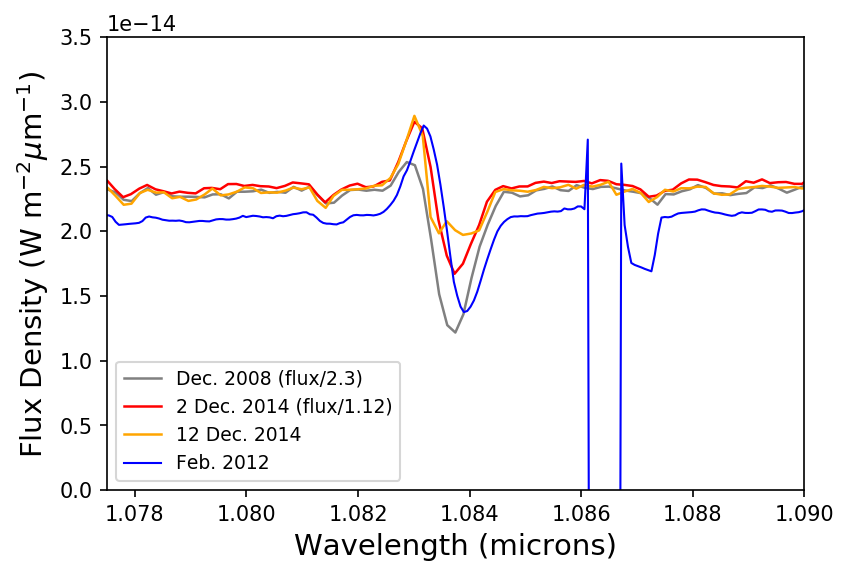

In [9]:
#Now zoom in on HeI 10830 and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/2.3, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/2.3)')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux/1.12, linewidth = 1.2, color = 'red', label = '2 Dec. 2014 (flux/1.12)')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')

plt.plot(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth =1, color = 'blue', label = 'Feb. 2012')
#plt.plot(IRSpec_2012_wavelength_air, Filtered_IRSpec_2012_flux, linewidth =1, color = 'magenta', label = 'Feb. 2012')

plt.axis([1.0775,1.09,0,0.35E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.savefig('HeI.png', bbox_inches='tight')

### Just plot photospheric features as a sanity check

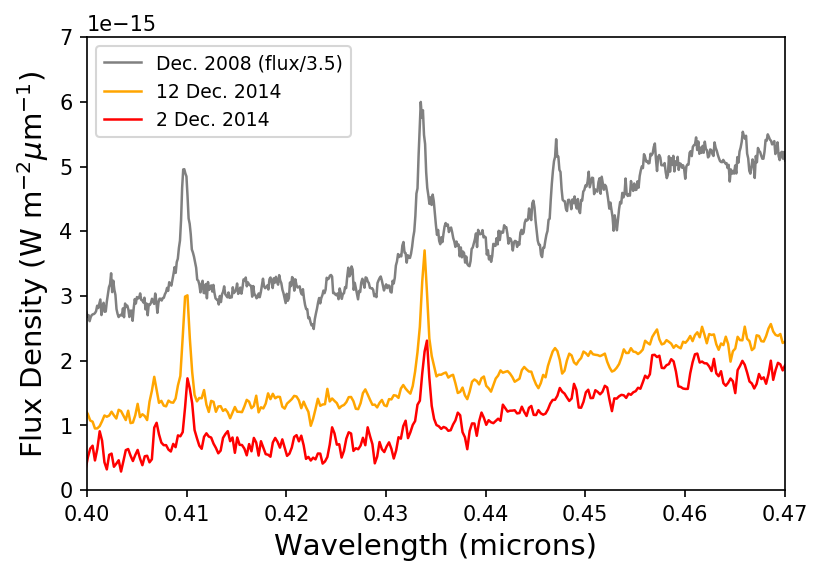

In [10]:
## Plot the bluer portion of the spectrum feature
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux/3.5, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/3.5)')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
#plt.plot(OptSpec_2012_wavelength, OptSpec_2012_flux, linewidth = 1.2, color = 'blue', label = 'Feb. 2012')

plt.axis([0.4,0.47,0e-14,0.7E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.savefig('Gband.png', bbox_inches='tight')

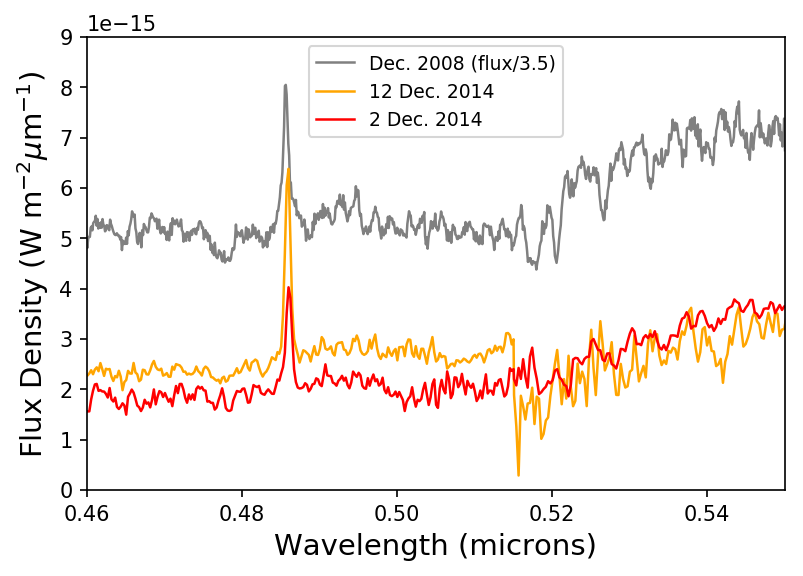

In [11]:
## Plot the bluer portion of the spectrum feature
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux/3.5, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/3.5)')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
#plt.plot(OptSpec_2012_wavelength, OptSpec_2012_flux, linewidth = 1.2, color = 'blue', label = 'Feb. 2012')

plt.axis([0.46,0.55,0e-14,0.9E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.savefig('MgI5150.png', bbox_inches='tight')

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


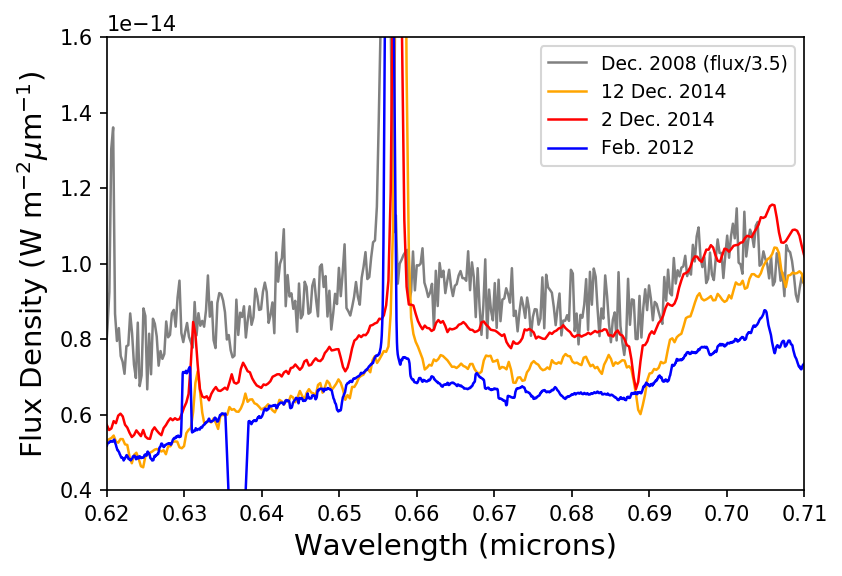

In [12]:
## Plot the bluer portion of the spectrum feature
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux/3.5, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/3.5)')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(OptSpec_2012_wavelength[n_opt_smooth_over2:-n_opt_smooth_over2], Filtered_OptSpec_2012_flux, linewidth = 1.2, color = 'blue', label = 'Feb. 2012')

plt.axis([0.62,0.71,0.4e-14,1.6E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.savefig('TiO6250_6800.png', bbox_inches='tight')

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


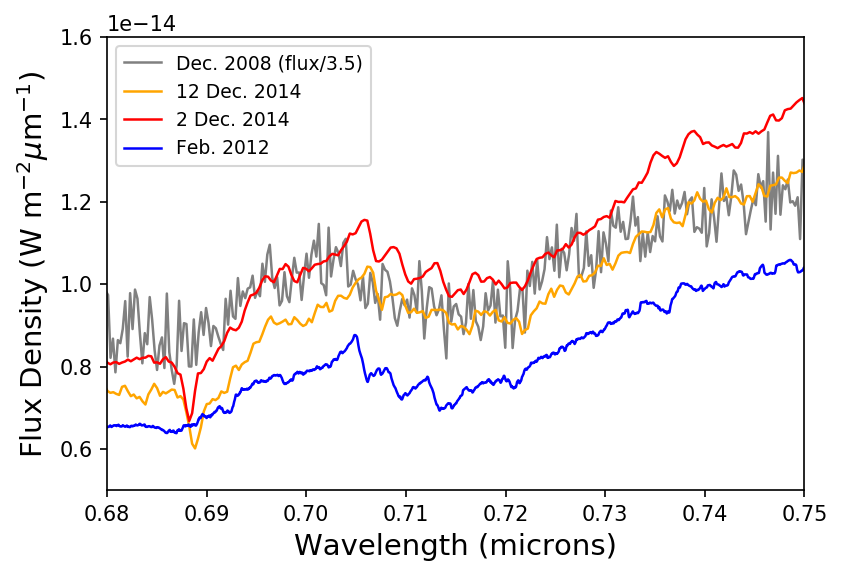

In [13]:
## Plot the TiO5 feature
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux/3.5, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/3.5)')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(OptSpec_2012_wavelength[n_opt_smooth_over2:-n_opt_smooth_over2], Filtered_OptSpec_2012_flux, linewidth = 1.2, color = 'blue', label = 'Feb. 2012')

plt.axis([0.68,0.75,0.5e-14,1.6E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.savefig('TiO5.png', bbox_inches='tight')

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


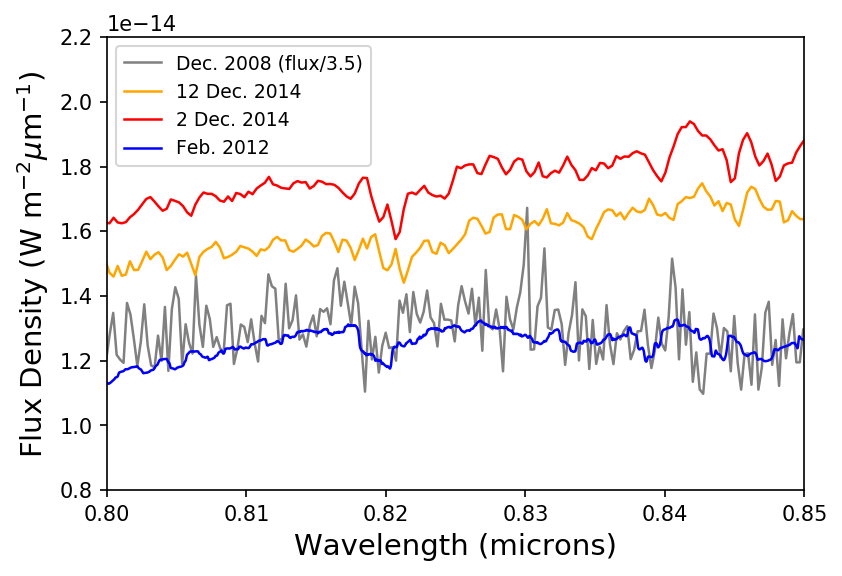

In [14]:
## Plot the Na D feature
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux/3.5, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/3.5)')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(OptSpec_2012_wavelength[n_opt_smooth_over2:-n_opt_smooth_over2], Filtered_OptSpec_2012_flux,  linewidth = 1.2, color = 'blue', label = 'Feb. 2012')

plt.axis([0.8,0.85,0.8e-14,2.2E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.savefig('NaD.png', bbox_inches='tight')

### Now move to H & K-band lines

In [15]:
#first measure lines in all the NIR spectra
NIR_EqWs_2008, NIR_fluxes_2008, LineIDs_2008, LineCenters_2008 = measure_Covey2010lines(IRSpec_2008_wavelength, IRSpec_2008_flux)
NIR_EqWs_2012, NIR_fluxes_2012, LineIDs_2012, LineCenters_2012 = measure_Covey2010lines(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux)
NIR_EqWs_dec2_2014, NIR_fluxes_dec2_2014, LineIDs_dec2_2014, LineCenters_dec2_2014  = measure_Covey2010lines(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux)
NIR_EqWs_dec12_2014, NIR_fluxes_dec12_2014, LineIDs_dec12_2014, LineCenters_dec12_2014  = measure_Covey2010lines(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux)
print('Line Depths [normalized to 2008; larger number -> stronger lines]')
print('Line     2008     2012         dec. 2 2014    dec. 12 2014')
print('1.50 Mg :', NIR_EqWs_2008[0]/NIR_EqWs_2008[0], NIR_EqWs_2012[0]/NIR_EqWs_2008[0], NIR_EqWs_dec2_2014[0]/NIR_EqWs_2008[0], NIR_EqWs_dec12_2014[0]/NIR_EqWs_2008[0])
print('1.58 Mg :', NIR_EqWs_2008[2]/NIR_EqWs_2008[2], NIR_EqWs_2012[2]/NIR_EqWs_2008[2], NIR_EqWs_dec2_2014[2]/NIR_EqWs_2008[2], NIR_EqWs_dec12_2014[2]/NIR_EqWs_2008[2])
print('1.59 Si :', NIR_EqWs_2008[3]/NIR_EqWs_2008[3], NIR_EqWs_2012[3]/NIR_EqWs_2008[3], NIR_EqWs_dec2_2014[3]/NIR_EqWs_2008[3], NIR_EqWs_dec12_2014[3]/NIR_EqWs_2008[3])
print('1.67 Al :', NIR_EqWs_2008[6]/NIR_EqWs_2008[6], NIR_EqWs_2012[6]/NIR_EqWs_2008[6], NIR_EqWs_dec2_2014[6]/NIR_EqWs_2008[6], NIR_EqWs_dec12_2014[6]/NIR_EqWs_2008[6])
print('1.71 Mg :', NIR_EqWs_2008[8]/NIR_EqWs_2008[8], NIR_EqWs_2012[8]/NIR_EqWs_2008[8], NIR_EqWs_dec2_2014[8]/NIR_EqWs_2008[8], NIR_EqWs_dec12_2014[8]/NIR_EqWs_2008[8])
print('2.21 Na :', NIR_EqWs_2008[10]/NIR_EqWs_2008[10], NIR_EqWs_2012[10]/NIR_EqWs_2008[10], NIR_EqWs_dec2_2014[10]/NIR_EqWs_2008[10], NIR_EqWs_dec12_2014[10]/NIR_EqWs_2008[10])
print('2.26 Ca :', NIR_EqWs_2008[11]/NIR_EqWs_2008[11], NIR_EqWs_2012[11]/NIR_EqWs_2008[11], NIR_EqWs_dec2_2014[11]/NIR_EqWs_2008[11], NIR_EqWs_dec12_2014[11]/NIR_EqWs_2008[11])
print('2.30 CO :', NIR_EqWs_2008[12]/NIR_EqWs_2008[12], NIR_EqWs_2012[12]/NIR_EqWs_2008[12], NIR_EqWs_dec2_2014[12]/NIR_EqWs_2008[12], NIR_EqWs_dec12_2014[12]/NIR_EqWs_2008[12])

Line Depths [normalized to 2008; larger number -> stronger lines]
Line     2008     2012         dec. 2 2014    dec. 12 2014
1.50 Mg : 1.0 0.875148524869 0.974263671551 0.97919493452
1.58 Mg : 1.0 0.938850174584 0.912306069565 0.832970051412
1.59 Si : 1.0 0.94346109805 0.882086452002 0.730966043861
1.67 Al : 1.0 1.02197857698 0.967277984066 0.916406110753
1.71 Mg : 1.0 0.93418650087 0.859259105167 0.811719912245
2.21 Na : 1.0 0.837687560969 0.765400418249 0.740706262139
2.26 Ca : 1.0 0.794508381981 0.763886682335 0.745061411616
2.30 CO : 1.0 0.782981757118 0.607539628692 0.556538880524


/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


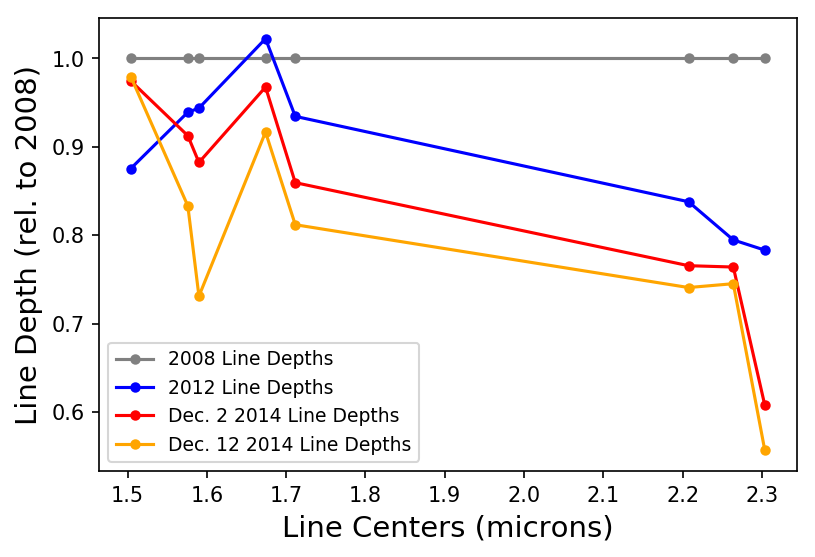

In [16]:
lines_to_use = [0,2,3,6,8,10,11,12]
LineStrengths2008 = np.array(NIR_EqWs_2008)
LineStrengths2012 = np.array(NIR_EqWs_2012)
LineStrengthsDec2_2014 = np.array(NIR_EqWs_dec2_2014)
LineStrengthsDec12_2014 = np.array(NIR_EqWs_dec12_2014)
LineCenters = np.array(LineCenters_2008)
LineCentersToUse = LineCenters[lines_to_use]
LineStrengthsToUse_2008 = LineStrengths2008[lines_to_use]
LineStrengthsToUse_2012 = LineStrengths2012[lines_to_use]
LineStrengthsToUse_dec2_2014 = LineStrengthsDec2_2014[lines_to_use]
LineStrengthsToUse_dec12_2014 = LineStrengthsDec12_2014[lines_to_use]
plt.plot(LineCentersToUse, LineStrengthsToUse_2008/LineStrengthsToUse_2008, marker= 'o', color = 'grey', label = '2008 Line Depths')
plt.plot(LineCentersToUse, LineStrengthsToUse_2012/LineStrengthsToUse_2008, marker= 'o', color = 'blue', label = '2012 Line Depths')
plt.plot(LineCentersToUse, LineStrengthsToUse_dec2_2014/LineStrengthsToUse_2008, marker= 'o', color = 'red', label = 'Dec. 2 2014 Line Depths')
plt.plot(LineCentersToUse, LineStrengthsToUse_dec12_2014/LineStrengthsToUse_2008, marker= 'o', color = 'orange', label = 'Dec. 12 2014 Line Depths')
xlabel = plt.xlabel('Line Centers (microns)') 
ylabel = plt.ylabel('Line Depth (rel. to 2008)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.savefig('H+K_LineDepths.png', bbox_inches='tight')

In [33]:
#now measure UV lines. 
uv_EqWs_2008, uv_fluxes_2008, uvLineIDs_2008, optLineCenters_2008 = measure_UVlines(OptSpec_2008_wavelength, OptSpec_2008_flux)
uv_EqWs_2012, uv_fluxes_2012, uvLineIDs_2012, optLineCenters_2012 = measure_UVlines(UVSpec_2012_wavelength, UVSpec_2012_flux)
uv_EqWs_dec2_2014, uv_fluxes_dec2_2014, uvLineIDs_dec2_2014, uvLineCenters_dec2_2014  = measure_UVlines(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux)
uv_EqWs_dec12_2014, uv_fluxes_dec12_2014, uvLineIDs_dec12_2014, uvLineCenters_dec12_2014  = measure_UVlines(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux)

Filtered_UVSpec_2012_flux = running_mean(UVSpec_2012_flux, n_uv_smooth)

UVSpec_2012_wavelength_air 

#HbetaEqW_2008, HbetaFluxW_2008, hbeta_wave_2008, hbeta_flux_2008 = measureEqW(OptSpec_2008_wavelength, OptSpec_2008_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
#HbetaEqW_2012, HbetaFluxW_2012,  hbeta_wave_2012, hbeta_flux_2012 = measureEqW(UVSpec_2012_wavelength, UVSpec_2012_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
#HbetaEqW_2dec2014, HbetaFluxW_2dec2014,  hbeta_wave_2dec2014, hbeta_flux_2dec2014 = measureEqW(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
#HbetaEqW_12dec2014, HbetaFluxW_12dec2014, hbeta_wave_12dec2014, hbeta_flux_12dec2014 = measureEqW(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)

print('Line Depths [normalized to 2008; larger number -> stronger lines]')
print('Line     2008     2012         dec. 2 2014    dec. 12 2014')
print('G Band :', uv_EqWs_2008[0]/uv_EqWs_2008[0], uv_EqWs_2012[0]/uv_EqWs_2008[0], uv_EqWs_dec2_2014[0]/uv_EqWs_2008[0], uv_EqWs_dec12_2014[0]/uv_EqWs_2008[0])
print('5172 Mg I :', uv_EqWs_2008[1]/uv_EqWs_2008[1], uv_EqWs_2012[1]/uv_EqWs_2008[1], uv_EqWs_dec2_2014[1]/uv_EqWs_2008[1], uv_EqWs_dec12_2014[1]/uv_EqWs_2008[1])
print('R5150 :', uv_EqWs_2008[2]/uv_EqWs_2008[2], uv_EqWs_2012[2]/uv_EqWs_2008[2], uv_EqWs_dec2_2014[2]/uv_EqWs_2008[2], uv_EqWs_dec12_2014[2]/uv_EqWs_2008[2])


Line Depths [normalized to 2008; larger number -> stronger lines]
Line     2008     2012         dec. 2 2014    dec. 12 2014
G Band : 1.0 1.43974030667 1.61512106035 1.03265118752
5172 Mg I : 1.0 0.579294717007 -5.72093565748 17.8236618303
R5150 : 1.0 0.95092037046 -0.156701173728 -0.680436436223


In [36]:
#now measure UV lines. 
opt_EqWs_2008, opt_fluxes_2008, optLineIDs_2008, optLineCenters_2008 = measure_Optlines(OptSpec_2008_wavelength, OptSpec_2008_flux)
opt_EqWs_2012, opt_fluxes_2012, optLineIDs_2012, optLineCenters_2012 = measure_Optlines(OptSpec_2012_wavelength, OptSpec_2012_flux)
opt_EqWs_dec2_2014, opt_fluxes_dec2_2014, optLineIDs_dec2_2014, optLineCenters_dec2_2014  = measure_Optlines(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux)
opt_EqWs_dec12_2014, opt_fluxes_dec12_2014, optLineIDs_dec12_2014, optLineCenters_dec12_2014  = measure_Optlines(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux)

#Filtered_UVSpec_2012_flux = running_mean(UVSpec_2012_flux, n_uv_smooth)

#UVSpec_2012_wavelength_air 

#HbetaEqW_2008, HbetaFluxW_2008, hbeta_wave_2008, hbeta_flux_2008 = measureEqW(OptSpec_2008_wavelength, OptSpec_2008_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
#HbetaEqW_2012, HbetaFluxW_2012,  hbeta_wave_2012, hbeta_flux_2012 = measureEqW(UVSpec_2012_wavelength, UVSpec_2012_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
#HbetaEqW_2dec2014, HbetaFluxW_2dec2014,  hbeta_wave_2dec2014, hbeta_flux_2dec2014 = measureEqW(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
#HbetaEqW_12dec2014, HbetaFluxW_12dec2014, hbeta_wave_12dec2014, hbeta_flux_12dec2014 = measureEqW(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)

print('Line Depths [normalized to 2008; larger number -> stronger lines]')
print('Line     2008     2012         dec. 2 2014    dec. 12 2014')
print('TiO 6250 :', opt_EqWs_2008[0]/opt_EqWs_2008[0], opt_EqWs_2012[0]/opt_EqWs_2008[0], opt_EqWs_dec2_2014[0]/opt_EqWs_2008[0], opt_EqWs_dec12_2014[0]/opt_EqWs_2008[0])
print('TiO 6800 :', opt_EqWs_2008[1]/opt_EqWs_2008[1], opt_EqWs_2012[1]/opt_EqWs_2008[1], opt_EqWs_dec2_2014[1]/opt_EqWs_2008[1], opt_EqWs_dec12_2014[1]/opt_EqWs_2008[1])
print('TiO 7140 :', opt_EqWs_2008[2]/opt_EqWs_2008[2], opt_EqWs_2012[2]/opt_EqWs_2008[2], opt_EqWs_dec2_2014[2]/opt_EqWs_2008[2], opt_EqWs_dec12_2014[2]/opt_EqWs_2008[2])
print('TiO 7700 :', opt_EqWs_2008[3]/opt_EqWs_2008[3], opt_EqWs_2012[3]/opt_EqWs_2008[3], opt_EqWs_dec2_2014[3]/opt_EqWs_2008[3], opt_EqWs_dec12_2014[3]/opt_EqWs_2008[3])
print('TiO 8465 :', opt_EqWs_2008[4]/opt_EqWs_2008[4], opt_EqWs_2012[4]/opt_EqWs_2008[4], opt_EqWs_dec2_2014[4]/opt_EqWs_2008[4], opt_EqWs_dec12_2014[4]/opt_EqWs_2008[4])


Line Depths [normalized to 2008; larger number -> stronger lines]
Line     2008     2012         dec. 2 2014    dec. 12 2014
TiO 6250 : 1.0 2.03039504363 1.77237899778 1.76840365974
TiO 6800 : 1.0 0.777468521523 1.12121755829 1.13697312543
TiO 7140 : 1.0 1.11346263017 0.419743204607 0.196983552986
TiO 7700 : 1.0 1.68663694677 1.16520515265 1.05974402298
TiO 8465 : 1.0 3.68788147877 -0.688326947275 -1.45304211214


In [36]:
#now measure UV lines. 
j_EqWs_2008, j_fluxes_2008, JLineIDs_2008, JLineCenters_2008 = measure_Jlines(IRSpec_2008_wavelength, IRSpec_2008_flux)
j_EqWs_2012, j_fluxes_2012, JLineIDs_2012, JLineCenters_2012 = measure_Jlines(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux)
j_EqWs_dec2_2014, j_fluxes_dec2_2014, JLineIDs_dec2_2014, JLineCenters_dec2_2014  = measure_Jlines(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux)
j_EqWs_dec12_2014, j_fluxes_dec12_2014, JLineIDs_dec12_2014, JLineCenters_dec12_2014  = measure_Jlines(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux,)

#Filtered_UVSpec_2012_flux = running_mean(UVSpec_2012_flux, n_uv_smooth)

#UVSpec_2012_wavelength_air 

#HbetaEqW_2008, HbetaFluxW_2008, hbeta_wave_2008, hbeta_flux_2008 = measureEqW(OptSpec_2008_wavelength, OptSpec_2008_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
#HbetaEqW_2012, HbetaFluxW_2012,  hbeta_wave_2012, hbeta_flux_2012 = measureEqW(UVSpec_2012_wavelength, UVSpec_2012_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
#HbetaEqW_2dec2014, HbetaFluxW_2dec2014,  hbeta_wave_2dec2014, hbeta_flux_2dec2014 = measureEqW(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)
#HbetaEqW_12dec2014, HbetaFluxW_12dec2014, hbeta_wave_12dec2014, hbeta_flux_12dec2014 = measureEqW(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, hbeta_line, hbeta_cont_blue, hbeta_cont_red)

print('Line Depths [normalized to 2008; larger number -> stronger lines]')
print('Line     2008     2012         dec. 2 2014    dec. 12 2014')
print(JLineIDs_2008[0], j_EqWs_2008[0]/j_EqWs_2008[0], j_EqWs_2012[0]/j_EqWs_2008[0], j_EqWs_dec2_2014[0]/j_EqWs_2008[0], j_EqWs_dec12_2014[0]/j_EqWs_2008[0])
print(JLineIDs_2008[1], j_EqWs_2008[1]/j_EqWs_2008[1], j_EqWs_2012[1]/j_EqWs_2008[1], j_EqWs_dec2_2014[1]/j_EqWs_2008[1], j_EqWs_dec12_2014[1]/j_EqWs_2008[1])
print(JLineIDs_2008[2], j_EqWs_2008[2]/j_EqWs_2008[2], j_EqWs_2012[2]/j_EqWs_2008[2], j_EqWs_dec2_2014[2]/j_EqWs_2008[2], j_EqWs_dec12_2014[2]/j_EqWs_2008[2])
print(JLineIDs_2008[3], j_EqWs_2008[3]/j_EqWs_2008[3], j_EqWs_2012[3]/j_EqWs_2008[3], j_EqWs_dec2_2014[3]/j_EqWs_2008[3], j_EqWs_dec12_2014[3]/j_EqWs_2008[3])
print(JLineIDs_2008[4], j_EqWs_2008[4]/j_EqWs_2008[4], j_EqWs_2012[4]/j_EqWs_2008[4], j_EqWs_dec2_2014[4]/j_EqWs_2008[4], j_EqWs_dec12_2014[4]/j_EqWs_2008[4])
print(JLineIDs_2008[0], j_EqWs_2008[0]/j_EqWs_2008[5], j_EqWs_2012[0]/j_EqWs_2008[0], j_EqWs_dec2_2014[0]/j_EqWs_2008[0], j_EqWs_dec12_2014[0]/j_EqWs_2008[0])
print(JLineIDs_2008[1], j_EqWs_2008[1]/j_EqWs_2008[6], j_EqWs_2012[1]/j_EqWs_2008[1], j_EqWs_dec2_2014[1]/j_EqWs_2008[1], j_EqWs_dec12_2014[1]/j_EqWs_2008[1])
print(JLineIDs_2008[2], j_EqWs_2008[2]/j_EqWs_2008[7], j_EqWs_2012[2]/j_EqWs_2008[2], j_EqWs_dec2_2014[2]/j_EqWs_2008[2], j_EqWs_dec12_2014[2]/j_EqWs_2008[2])
print(JLineIDs_2008[3], j_EqWs_2008[3]/j_EqWs_2008[8], j_EqWs_2012[3]/j_EqWs_2008[3], j_EqWs_dec2_2014[3]/j_EqWs_2008[3], j_EqWs_dec12_2014[3]/j_EqWs_2008[3])
print(JLineIDs_2008[4], j_EqWs_2008[4]/j_EqWs_2008[4], j_EqWs_2012[4]/j_EqWs_2008[4], j_EqWs_dec2_2014[4]/j_EqWs_2008[4], j_EqWs_dec12_2014[4]/j_EqWs_2008[4])

Line Depths [normalized to 2008; larger number -> stronger lines]
Line     2008     2012         dec. 2 2014    dec. 12 2014
TiO 6250 : 1.0 2.03039504363 1.77237899778 1.76840365974
TiO 6800 : 1.0 0.777468521523 1.12121755829 1.13697312543
TiO 7140 : 1.0 1.11346263017 0.419743204607 0.196983552986
TiO 7700 : 1.0 1.68663694677 1.16520515265 1.05974402298
TiO 8465 : 1.0 3.68788147877 -0.688326947275 -1.45304211214


/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


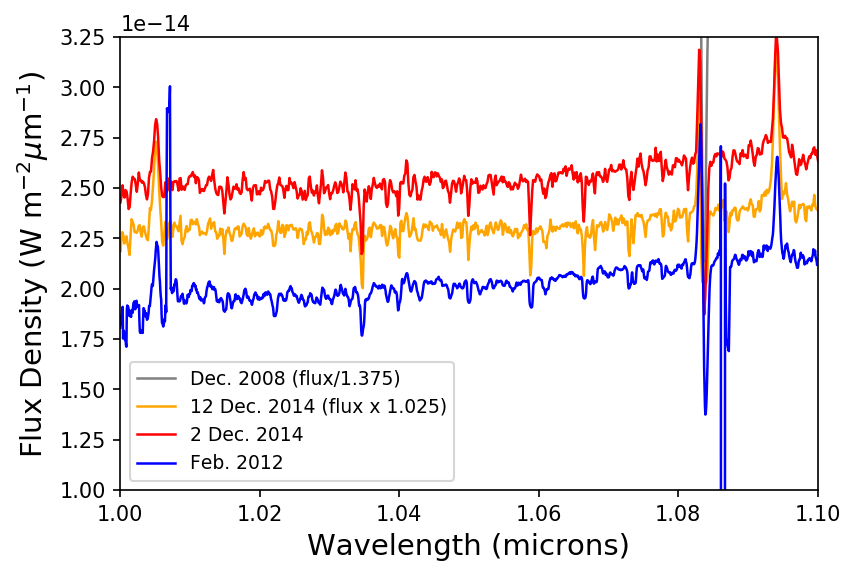

In [17]:
#zoom in on the ~1.0 micron K and Mg lines and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.375, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/1.375)')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.025, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014 (flux x 1.025)')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth = 1.2, color = 'blue', label = 'Feb. 2012')

plt.axis([1.,1.1,1E-14,3.25E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")
plt.savefig('Yband.png', bbox_inches='tight')


/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


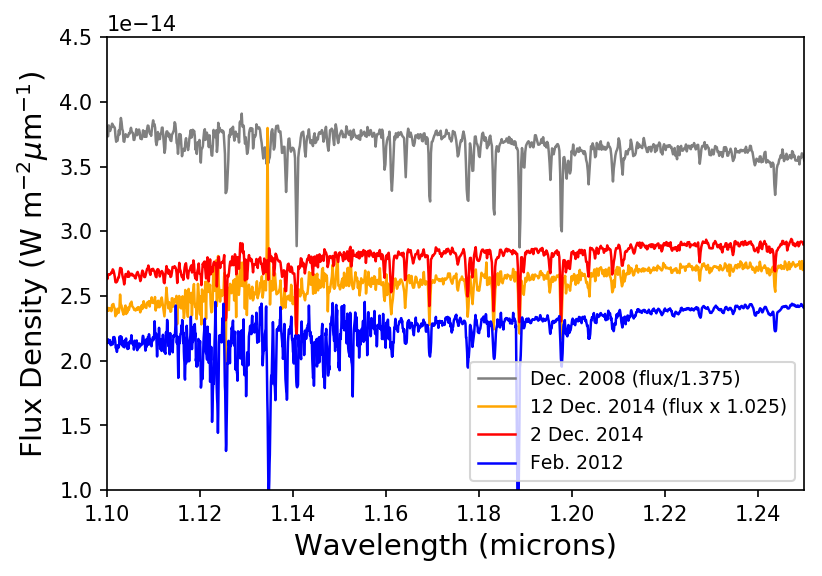

In [25]:
#zoom in on the ~1.1 micron K and Mg lines and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.375, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/1.375)')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.025, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014 (flux x 1.025)')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth = 1.2, color = 'blue', label = 'Feb. 2012')

plt.axis([1.1,1.25,1E-14,4.5E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")
plt.savefig('Yband_2.png', bbox_inches='tight')


/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


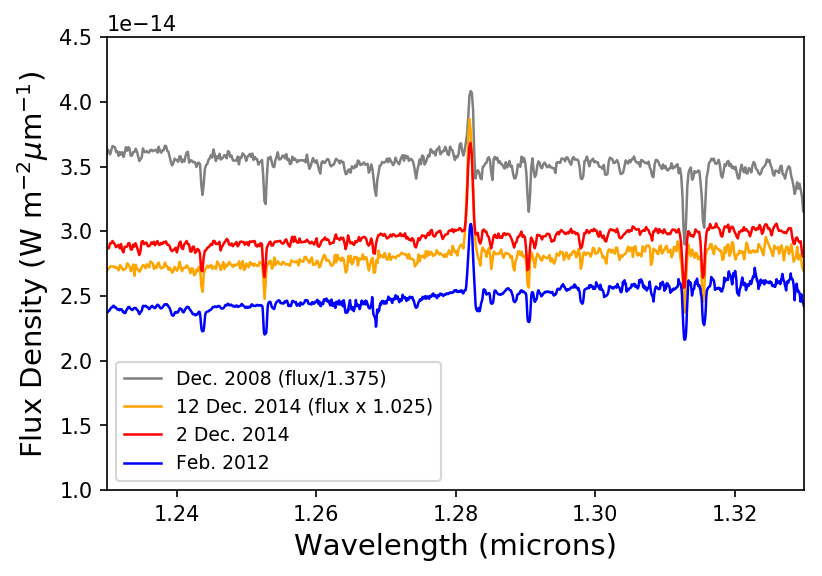

In [19]:
#zoom in on the ~1.2 micron K and Mg lines and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.375, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/1.375)')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.025, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014 (flux x 1.025)')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth = 1.2, color = 'blue', label = 'Feb. 2012')

plt.axis([1.23,1.33,1E-14,4.5E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")
plt.savefig('Jband.png', bbox_inches='tight')


/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


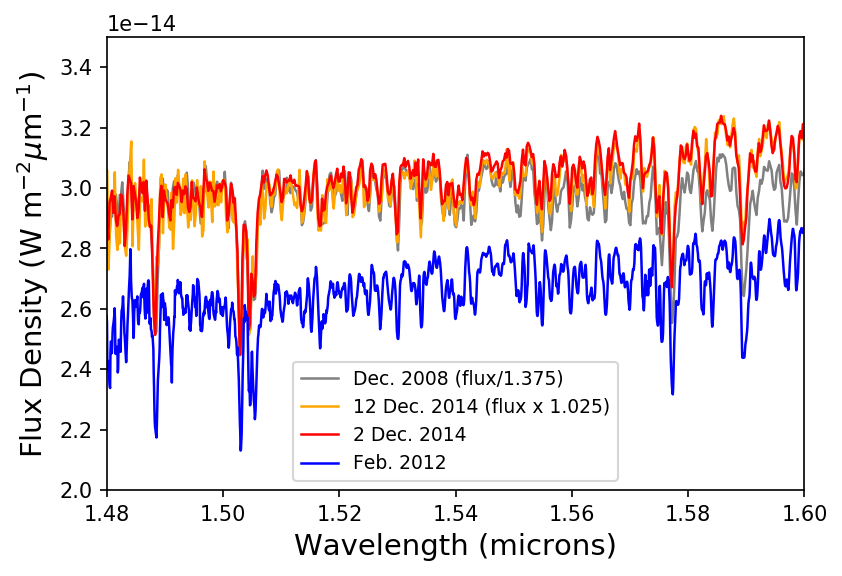

In [20]:
#zoom in on the ~1.5 micron K and Mg lines and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.375, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/1.375)')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.025, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014 (flux x 1.025)')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth = 1.2, color = 'blue', label = 'Feb. 2012')

plt.axis([1.48,1.6,2E-14,3.5E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")
plt.savefig('Hband_K+Mg.png', bbox_inches='tight')


/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


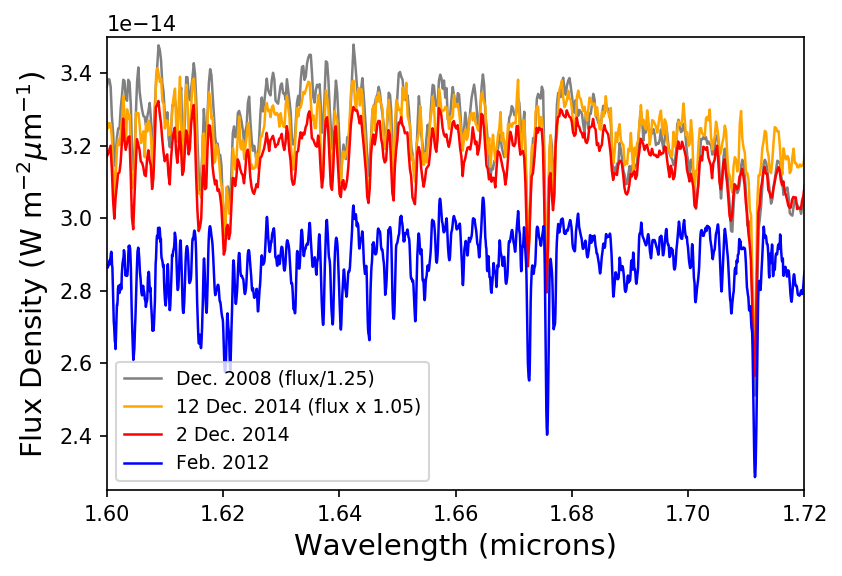

In [21]:
#Now zoom in on the ~1.7 micron Al and Mg lines and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.25, linewidth = 1.2, color = 'grey', label = 'Dec. 2008 (flux/1.25)')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.05, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014 (flux x 1.05)')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth = 1.2, color = 'blue', label = 'Feb. 2012')


plt.axis([1.6,1.72,2.25E-14,3.5E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.savefig('Hband_Al+Mg.png', bbox_inches='tight')

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


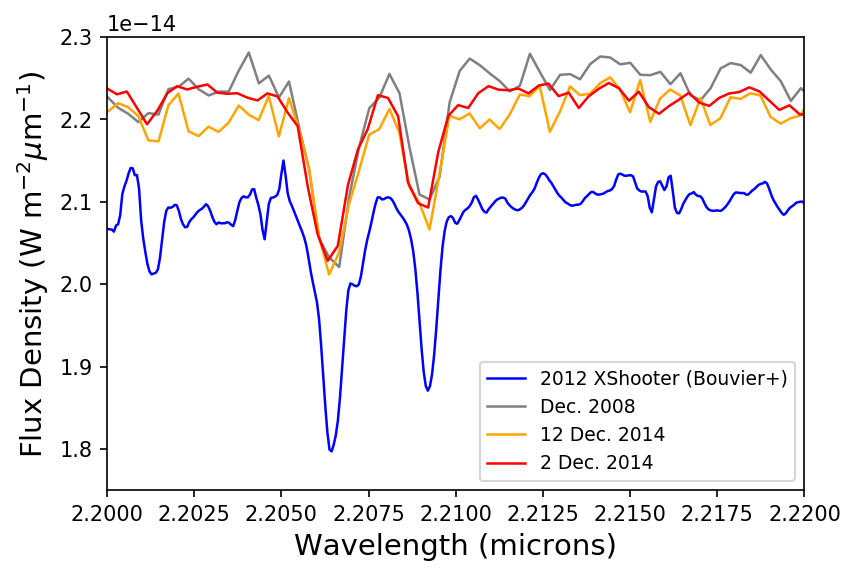

In [22]:
#Now zoom in on the 2.2 micron sodium doublet and compare the line profiles.
plt.plot(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth = 1.2, color = 'blue', label = '2012 XShooter (Bouvier+)')
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 1.2, color = 'grey', label = 'Dec. 2008')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')

#plt.plot(IRSpec_2012_wavelength, IRSpec_2012_flux*2.5, linewidth = 2, color = 'grey')

plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.axis([2.2,2.22,1.75E-14,2.3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.savefig('Kband_Na.png', bbox_inches='tight')

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


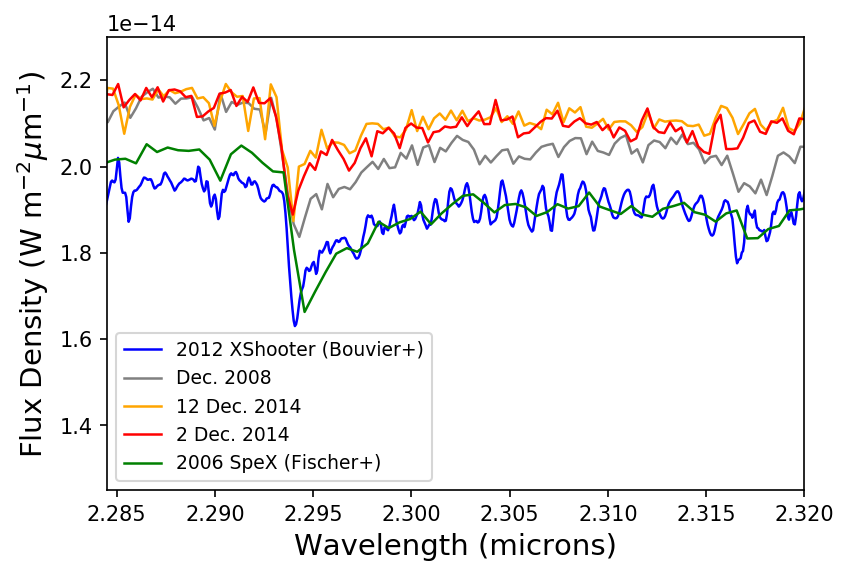

In [23]:
#Now zoom in on the 2.3 micron CO bandheads and compare the line profiles.
plt.plot(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth = 1.2, color = 'blue', label = '2012 XShooter (Bouvier+)')
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 1.2, color = 'grey', label = 'Dec. 2008')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(IRSpec_2006_wavelength, IRSpec_2006_flux, linewidth = 1.2, color = 'green', label = '2006 SpeX (Fischer+)')

plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.axis([2.2845,2.32,1.25E-14,2.3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.savefig('Kband_CO.png', bbox_inches='tight')

/Users/coveyk/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


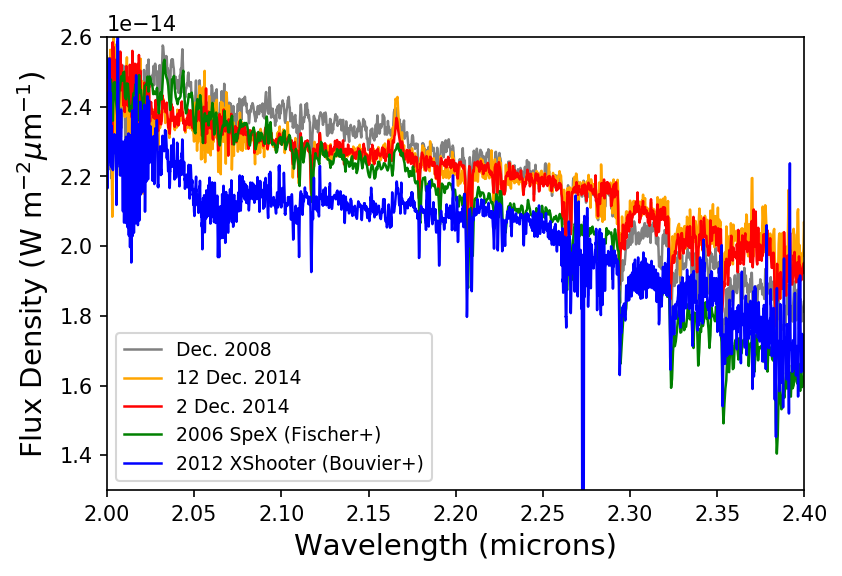

In [24]:
#Now zoom in on the 2.3 micron CO bandheads and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 1.2, color = 'grey', label = 'Dec. 2008')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 1.2, color = 'orange', label = '12 Dec. 2014')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 1.2, color = 'red', label = '2 Dec. 2014')
plt.plot(IRSpec_2006_wavelength, IRSpec_2006_flux, linewidth = 1.2, color = 'green', label = '2006 SpeX (Fischer+)')
plt.plot(IRSpec_2012_wavelength[n_nir_smooth_over2:-n_nir_smooth_over2], Filtered_IRSpec_2012_flux, linewidth = 1.2, color = 'blue', label = '2012 XShooter (Bouvier+)')

plt.rcParams['legend.fontsize'] = 9
plt.legend(loc="best")

plt.axis([2,2.4,1.3E-14,2.6E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
plt.savefig('Kband.png', bbox_inches='tight')

## Below here is useless -- useless, I say, useless! (except apparently I'm too lazy to delete it)

NameError: name 'optSpec_2012_wavelength' is not defined

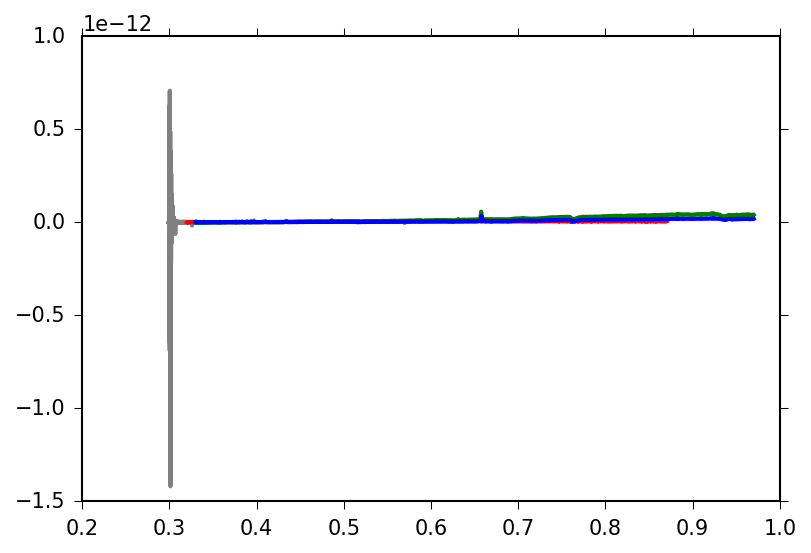

In [21]:
#Now zoom in on Balmer Jump and compute the EqW.
plt.plot(UVSpec_2012_wavelength, UVSpec_2012_flux*1.3, linewidth = 2, color = 'grey')

plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux/7.5, linewidth = 2, color = 'red')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux*2, linewidth = 2, color = 'green')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 2, color = 'blue')

plt.plot(optSpec_2012_wavelength, optSpec_2012_flux, linewidth = 2, color = 'grey')
#plt.plot(UVSpec_2012_wavelength, UVSpec_2012_flux, linewidth = 2, color = 'grey')

plt.axis([0.35,0.415,0,0.8E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????


In [ ]:
#Now zoom in on Hbeta and compute the EqW.
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux/3, linewidth = 2, color = 'red')
plt.plot(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, linewidth = 2, color = 'blue')

plt.plot(optSpec_2012_wavelength, optSpec_2012_flux, linewidth = 2, color = 'grey')
plt.plot(UVSpec_2012_wavelength, UVSpec_2012_flux, linewidth = 2, color = 'grey')

plt.axis([0.755,0.77,0,7E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

plt.savefig('Aband_telluricAbsorption.png', bbox_inches='tight')

#HbetaEqW_2008 = measure_eqw(OptSpec_2008_wavelength, OptSpec_2008_flux, 0.4845, 0.487, 0.48, 0.483, 
#                         0.489, 0.492, trapsum=False)
#print('2008 Hbeta: ', HbetaEqW_2008)

#HbetaEqW_dec2_2014 = measure_eqw(OptSpec_dec2_2014_wavelength, OptSpec_dec2_2014_flux, 0.4845, 0.487, 0.48, 0.483, 
#                         0.489, 0.492, trapsum=False)
#print('Dec 2 2014 Hbeta: ', HbetaEqW_dec2_2014)

#HbetaEqW_dec12_2014 = measure_eqw(OptSpec_dec12_2014_wavelength, OptSpec_dec12_2014_flux, 0.4845, 0.487, 0.48, 0.483, 
#                         0.489, 0.492, trapsum=False)
#print('Dec 12 2014 Hbeta: ', HbetaEqW_dec12_2014)

In [ ]:
#Now zoom in on PaDelta and compute the EqW.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 2, color = 'blue')
#originally I could only see two spectra in this plot, so add an offset to the dec 2nd to show
#that it is exactly the same as the dec12...
#plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux+1e-14, linewidth = 2, color = 'orange')

plt.plot(IRSpec_2012_wavelength, IRSpec_2012_flux, linewidth = 2, color = 'grey')


plt.axis([0.99,1.02,0,1E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

#WHY IS THIS EQUIVALENT WIDTH MEASUREMENT NOT WORKING?!?!?!?!
#PaDelta_EqW_2008 = measure_eqw(IRSpec_2008_wavelength, IRSpec_2008_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=True)
#print('2008 PaDelta: ', PaDelta_EqW_2008)

#PaDelta_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 12 2014 PaDelta: ', PaDelta_dec12_2014)

#PaDelta_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 2 2014 PaDelta: ', PaDelta_dec12_2014)

In [ ]:
#Now zoom in on Paschen beta and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.8, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 2, color = 'blue')

plt.plot(IRSpec_2012_wavelength, IRSpec_2012_flux, linewidth = 2, color = 'grey')

plt.axis([1.27,1.29,0,0.4E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

#PaBeta_EqW_2008 = measure_eqw(IRSpec_2008_wavelength, IRSpec_2008_flux, 1.281, 1.2835, 1.275, 1.2775, 
#                         1.286, 1.2885, trapsum=True)
#print('2008 PaBeta: ', PaBeta_EqW_2008)

#PaBeta_EqW_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 1.281, 1.2835, 1.275, 1.2775, 
#                         1.286, 1.2885, trapsum=True)
#print('Dec. 2 2014 PaBeta: ', PaBeta_EqW_dec2_2014)


#PaBeta_EqW_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 1.281, 1.2835, 1.275, 1.2775, 
#                         1.286, 1.2885, trapsum=True)
#print('Dec. 12 2014 PaBeta: ', PaBeta_EqW_dec12_2014)


#PaDelta_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 12 2014 PaDelta: ', PaDelta_dec12_2014)

#PaDelta_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 2 2014 PaDelta: ', PaDelta_dec12_2014)

In [ ]:
#Now zoom in on Brackett gamma and compare the line profiles.
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, linewidth = 2, color = 'blue')

plt.plot(IRSpec_2012_wavelength, IRSpec_2012_flux, linewidth = 2, color = 'grey')

plt.axis([2.13,2.2,0,3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

#BrGamma_EqW_2008 = measure_eqw(IRSpec_2008_wavelength, IRSpec_2008_flux, 2.15, 2.1575, 2.1625, 2.17, 
#                         2.1725, 2.18, trapsum=True)
#print('2008 BrGamma: ', BrGamma_EqW_2008)

#BrGamma_EqW_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 2.15, 2.1575, 2.1625, 2.17, 
#                         2.1725, 2.18, trapsum=True)
#print('Dec. 2 2014 BrGamma: ', BrGamma_EqW_dec2_2014)


#BrGamma_EqW_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 2.15, 2.1575, 2.1625, 2.17, 
#                         2.1725, 2.18, trapsum=True)
#print('Dec. 12 2014 BrGamma: ', BrGamma_EqW_dec12_2014)


#PaDelta_dec12_2014 = measure_eqw(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 12 2014 PaDelta: ', PaDelta_dec12_2014)

#PaDelta_dec2_2014 = measure_eqw(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, 1.004, 1.006, 0.999, 1.001, 
#                         1.008, 1.01, trapsum=False)
#print('Dec 2 2014 PaDelta: ', PaDelta_dec12_2014)

In [ ]:
#Now zoom in on the ~1.2 micron Na, Al and Fe lines and compare the line profiles.
plt.plot(optSpec_2012_wavelength, optSpec_2012_flux*2.9, linewidth = 2, color = 'grey')

plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.125, linewidth = 2, color = 'blue')
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/2.2, linewidth = 2, color = 'red')

plt.axis([0.95,1.03,1.5E-14,3.25E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????


In [ ]:
#Now zoom in on the ~1.2 micron Na, Al and Fe lines and compare the line profiles.
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.15, linewidth = 2, color = 'blue')
plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/2, linewidth = 2, color = 'red')

plt.plot(IRSpec_2012_wavelength, IRSpec_2012_flux*3.5, linewidth = 2, color = 'grey')

plt.axis([1.12,1.21,0E-14,3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????


In [ ]:
#Now zoom in on the ~1.2 micron Na, Al and Fe lines and compare the line profiles.
#plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux/1.5, linewidth = 2, color = 'red')
plt.plot(IRSpec_dec2_2014_wavelength, IRSpec_dec2_2014_flux, linewidth = 2, color = 'green')
plt.plot(IRSpec_dec12_2014_wavelength, IRSpec_dec12_2014_flux*1.1, linewidth = 2, color = 'blue')

plt.plot(IRSpec_2012_wavelength, IRSpec_2012_flux, linewidth = 2, color = 'grey')


plt.axis([1.12,1.21,2.0E-14,3.3E-14])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m$^{-2} \mu$m$^{-1}$)')  #ARE THESE ACTUALLY THE RIGHT UNITS????
